<a href="https://colab.research.google.com/github/Veronika2311/NNmethods_21/blob/main/hw2/%D1%81nn_6_Part6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

понятное [видео](https://www.youtube.com/watch?v=bNb2fEVKeEo) со стенфордского курса, из [материалов](https://cs231n.github.io/convolutional-networks) по которому взяты иллюстрации.

Датасет из [курса](https://github.com/DanAnastasyev/DeepNLP-Course/blob/master/Week%2004/Week_04_Convolutional_Neural_Networks.ipynb) Даниила Анастасьева.

Использовались [материалы](https://github.com/mannefedov/hse_ml_m1/blob/master/7_cnn/cnn.ipynb) из курса Михаила Нефедова.

# Сверточный слой




Желтое - фильтр (= filter,kernel).

Зеленое - входные данные, например, изображение.

Розовое - карта активации (activation map).

Каждый элемент в розовой матрице - результат поэлементного умножения фильтра на числа из области на входных данных.
Обучаемые параметры - элементы фильтра.

![Conv](https://image.ibb.co/e6t8ZK/Convolution.gif)



Чтобы не терять размер матрицы используется паддинг.

![padding](https://3deep.ru/wp-content/uploads/2020/01/keras_conv2d_padding.gif)

from https://3deep.ru/machinelearning/

# Pooling слой  (не обучается)

![Pool](https://cs231n.github.io/assets/cnn/pool.jpeg)
![maxpool](https://cs231n.github.io/assets/cnn/maxpool.jpeg)

# Свертки для текстов устроены немного по-другому. В них на одну размерность меньше.

![text-convs](https://image.ibb.co/bC3Xun/2018_03_27_01_24_39.png)

From [Character-Aware Neural Language Models](https://arxiv.org/pdf/1508.06615.pdf)

# CNN для обработки текстов



In [ ]:
!pip install torchmetrics

In [ ]:
!pip install ipdb

In [ ]:
import pandas as pd
import numpy as np
from string import punctuation
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torchmetrics import F1
from torchmetrics.functional import f1, recall
import ipdb
from tqdm import tqdm

### Слова



### Скачивание и подготовка данных

Уберём же пунктуацию, нам помогающую

In [ ]:
train_data =  pd.read_csv('train.csv', encoding='utf8')
val_data = pd.read_csv('val.csv', encoding='utf8')

In [ ]:
train_data[train_data.type == 1].shape[0] / train_data.shape[0]

0.5076624492263313

In [ ]:
train_data.head(50)

,Unnamed: 0,text,type,clean_texts
0,0,"эх, ехать на репу пора((\nЗавтра уже выступление.",0,"эх , ехать на репа пора ( ( завтра уже выступл..."
1,1,"Аллергия вышла,из-за этих тупых мандарин(((((((",0,"аллергия выйти , из - за этот тупой мандарин (..."
2,2,@KompaundTone550 @tatysho власть всегда была б...,1,"власть всегда была , просто теперь об знать ве..."
3,3,"@Alinockaa А хрен, я гулящая пока, потом насиж...",1,"а хрен , я пока , потом дома : dd но сегодня я..."
4,4,"RT @vik_vans: блин, слушала первый мини-альбом...",0,"rt @vik_vans : блин , слушать первый мини - ал..."
5,5,Как же не сделать фото на айфон в зеркале:-D h...,1,как же не сделать фото на айфон в
6,6,Заебись погулял... Мама пуховик постирала ;((,0,заебись погулял ... мама пуховик постирать ; ( (
7,7,#HappyBirthdayLouisfromCIS Почему я мало пиш...,0,# почему я мало писать в тви ; ( ( ( (
8,8,@cobyisnotalone ладно :(\nмне через полтора ча...,0,ладно :( мне через полтора час только
9,9,"@DashaSone вот да, это было бы идеально! Хочу ...",1,"вот да , это было бы идеальный ! хотеть все пр..."


In [ ]:
stops = '.,!#$@?)([]:;'
def preproc(text):
    text = str(text).split()
    res = []
    for i in text:
        if i not in stops:
            res.append(i)
    return ' '.join(res)

train_data['clean_texts'] = [preproc(i) for i in train_data['clean_texts']]
val_data['clean_texts'] = [preproc(i) for i in val_data['clean_texts']]

Почему мы можем трогать только train_data? Потому что иначе может попасть что-нибудь из теста. Вероятно, будет не очень заментно, но исключать возможность не стоит, и на уровне слов она больше, чем на уровне символов

In [ ]:
vocab = Counter()
for text in tqdm(train_data['clean_texts']):
    vocab.update(str(text).split(' '))
print('всего уникальных слов:', len(vocab))

100%|██████████| 94291/94291 [00:00<00:00, 174874.79it/s]

всего уникальных слов: 18061


In [ ]:
vocab['PAD']

0

In [ ]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 5:
        filtered_vocab.add(word)
    else:
        print(word) # мы всё в препроцессинге удалили
print('уникальных слов, встретившихся больше 5 раз:', len(filtered_vocab))

Выходные данные были обрезаны до нескольких последних строк (5000).
кетчуп
помешанный
совмещать
несовместимый
пересдать
95
дополнить
жеесть
пожалей
проделать
потанцевала
phone
су
уносить
@aww_sugar
@jyjcy_cassi
мерзко
котка
@meow_kiljjoy
@carne_nasse
@juliesvolt
нээх
rammstein
@sazam
перечислять
фууууу
гаишник
привязать
аспирин
антибиотик
умиление
@ivanromashikhin
вчора
бляяяяять
99((9
@filaretov_ia
актив
обновка
скууучно
яблочки
мел
5-ти
@69styleskate
воно
емес
зелёнка
вредить
@glukoza_ionova
@mitrofanbelov
лунный
прекрасного!=
порыться
53
@pink_slasher
@allaelesina
@brembotwit
чухал
харамсалтай
административный
ball
добрыйтвит
13ое
@ckahax
празднично
выйграла
бронхит
тленный
@starlight6vixx
каков
глагол
хотіла
аххаах
@hapumahh0055
депрессивный
цвести
топка
анфолловеры
дом-2
„
@wtf_not_found
@catherina_7
приложить
грибной
бездарность
окатить
сытный
@gordeev_tima
галактика
пуд
вскоре
хочеш
2015
@new_angeles1
издеваешься
аан
ирээд
@andrey_simon
противоречить
пересилить
развидеть
бух
вен

In [ ]:
#создаем словарь с индексами symbol2id, для спецсимвола паддинга дефолтный индекс - 0
word2id = {'PAD':0}
symbol2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)
    for symbol in word:
        if not symbol in symbol2id.keys():
            symbol2id[symbol] = len(symbol2id)

In [ ]:
#symbol2id # И ещё смайлики

In [ ]:
#обратный словарь для того, чтобы раскодировать последовательность
id2word = {i:word for word, i in word2id.items()}
id2symbol = {i:symbol for symbol, i in symbol2id.items()}

In [ ]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cuda')

## Эмбеддинги

Фасттекст так фасттекст, давайте возьмём для него леммы

In [ ]:
from gensim.models import FastText

In [ ]:
fasttext_data = [str(i) for i in train_data['clean_texts'].tolist()]

In [ ]:
model_fasttext = FastText(fasttext_data, size=64, window=5, min_count=5)

In [ ]:
model_embs = np.zeros((len(word2id), 64))
dict_of_non_wodel_embs = {} # логичнее для одинаковых слов использовать одинаковые эмбеддинги
len_non_model_words  = 0
# почему не случайные? потому что сейчас менять будем
for word, i in word2id.items():
    try:
        model_embs[i] = ft.wv[word]
    except:
        len_non_model_words += 1
        if word in dict_of_non_wodel_embs.keys():
            emb = dict_of_non_wodel_embs[word]
        else:
            emb = np.random.normal(0, 0.05, 64)
            dict_of_non_wodel_embs[word] = emb
        model_embs[i] = emb
print(len_non_model_words)

11034


### Dataset & DataLoader

In [ ]:
class TweetsDataset(Dataset):

    def __init__(self, dataset, word2id, DEVICE):
        self.dataset = [str(i) for i in dataset['clean_texts'].values]
        self.word2id = word2id
        self.symbol2id = symbol2id
        self.length = dataset.shape[0]
        self.target = dataset['type'].values
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        words = self.dataset[index].split(' ')
        symbols = list(self.dataset[index])
        words_ids = torch.LongTensor([self.word2id[word.lower()] for word in words if word.lower() in self.word2id])
        symbols_ids = torch.LongTensor([self.symbol2id[symbol.lower()] for symbol in symbols if symbol.lower() in self.symbol2id])
        y = [self.target[index]]
        return words_ids, symbols_ids, y

    def collate_fn(self, batch): #этот метод можно реализовывать и отдельно,
    # он понадобится для DataLoader во время итерации по батчам
        words_ids, symbols_ids, y = list(zip(*batch))
        
        padded_words_ids = pad_sequence(words_ids, batch_first=True).to(self.device)
        padded_symbols_ids = pad_sequence(symbols_ids, batch_first=True).to(self.device)
        y = torch.Tensor(y).to(self.device)
        return padded_words_ids, padded_symbols_ids, y

### создаем итераторы по данным для трейна и теста

In [ ]:
train_dataset = TweetsDataset(train_data, word2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=64)

In [ ]:
batch = next(iter(train_iterator))

In [ ]:
batch[0].shape

In [ ]:
#[id2word[int(i)] for i in batch[0][0]]

In [ ]:

batch[1]

In [ ]:
val_dataset = TweetsDataset(val_data, word2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=64)

In [ ]:
test_batch = next(iter(val_iterator))
test_batch[0].shape

### CNN model

In [ ]:
fm = torch.randn(3, 8, 4) #batch_size, num_filters, seq_len
fm

In [ ]:
mp = torch.nn.MaxPool1d(kernel_size=2, stride=2)
print(mp(fm).shape)
mp(fm)

In [ ]:
fm.max(2)[0]

Оставим фасттекст

In [ ]:
class CNN(nn.Module):
    
    def __init__(self, words_vocab_size, symbols_vocab_size, words_embedding_dim, symbols_embedding_dim, model_embs):
        super().__init__()
        self.words_embedding = nn.Embedding(words_vocab_size, words_embedding_dim)
        self.words_embedding.from_pretrained(torch.tensor(model_embs), freeze=True) # ничего нового, только название
        self.hidden_words = nn.Linear(words_embedding_dim, out_features=100)
        
        self.symbols_embedding = nn.Embedding(symbols_vocab_size, symbols_embedding_dim)        
        self.bigrams = nn.Conv1d(in_channels=symbols_embedding_dim, out_channels=100, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=symbols_embedding_dim, out_channels=80, kernel_size=3, padding='same')
        
        #self.concat_bigrams = nn.Conv1d(in_channels=180, out_channels=100, kernel_size=2, padding='same')
        self.pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=280, out_features=1)
        self.dropout = nn.Dropout(p=0.4)
        self.out = nn.Sigmoid()

    def forward(self, symbols, words):
        #batch_size x seq_len
        embedded_words = self.hidden_words(torch.mean(self.words_embedding(words), dim=1))
        
        embedded_symbols = self.symbols_embedding(symbols)
        
        #batch_size x seq_len x embedding_dim
        embedded_symbols = embedded_symbols.transpose(1,2)
        #batch_size x embedding_dim x seq_len
        feature_symbols_bigrams = self.dropout(self.pooling(self.relu(self.bigrams(embedded_symbols))))
        #batch_size x filter_count2 x seq_len* 
        feature_symbols_trigrams = self.dropout(self.pooling(self.relu(self.trigrams(embedded_symbols))))


        pooling1 = feature_symbols_bigrams.max(2)[0] 
        # batch_size x filter_count2
        pooling2 = feature_symbols_trigrams.max(2)[0]
        # batch_size x filter_count3
        concat = torch.cat((pooling1, pooling2, embedded_words), 1)
        

        logits = self.hidden(concat)
        logits = self.out(logits)
        
        return logits

In [ ]:
words_batch, sym_batch, y = next(iter(train_iterator))
words_batch, sym_batch, y = words_batch.to(device='cpu'), sym_batch.to(device='cpu'), y.to(device='cpu')
print(words_batch)

In [ ]:
#y

In [ ]:
model_embs.shape

In [ ]:
words_batch.shape

In [ ]:
sym_batch.shape

In [ ]:
model = CNN(len(id2word), len(id2symbol), 64, 8, model_embs)
output = model(sym_batch, words_batch)
#print(output)

In [ ]:
loss = nn.BCELoss()
loss(output, y)

In [ ]:
#f1(output, y.long())

### training loop, логика обучения и валидации

теперь нам нужны функции для обучения и валидации,
каждый вызов функции - одна эпоха обучения 

За одну эпоху нам надо для каждого батча:

-- применить к нему модель, 

-- посчитать значение функции потерь, 

-- посчитать градиенты,

-- обновить веса (параметры модели)


In [ ]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0 # для подсчета среднего лосса на всех батчах

    model.train()  # ставим модель в обучение, явно указываем, что сейчас надо будет хранить градиенты у всех весов

    for i, (words_batch, sym_batch, ys) in enumerate(iterator): #итерируемся по батчам
        optimizer.zero_grad()  #обнуляем градиенты
        preds = model(sym_batch, words_batch)  #прогоняем данные через модель
        loss = criterion(preds, ys) #считаем значение функции потерь  
        loss.backward() #считаем градиенты  
        optimizer.step() #обновляем веса 
        epoch_loss += loss.item() #сохраняем значение функции потерь
        if not (i + 1) % int(len(iterator)/5):
            print(f'Train loss: {epoch_loss/i}')      
    return  epoch_loss / len(iterator) # возвращаем среднее значение лосса по всей выборке

In [ ]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_metric = 0
    model.eval() 
    with torch.no_grad():
        for i, (words_batch, sym_batch, ys) in enumerate(iterator):   
            preds = model(sym_batch, words_batch)  # делаем предсказания на тесте
            loss = criterion(preds, ys)   # считаем значения функции ошибки для статистики  
            epoch_loss += loss.item()
            batch_metric = f1(preds.round().long(), ys.long(), ignore_index=0)
            epoch_metric += batch_metric

            if not (i + 1) % int(len(iterator)/5):
                print(f'Val loss: {epoch_loss/i}, Val f1: {epoch_metric/i}')
        
    return epoch_metric / len(iterator), epoch_loss / len(iterator) # возвращаем среднее значение по всей выборке

### инициализируем модель, задаем оптимизатор и функцию потерь

In [ ]:
model = CNN(len(id2word), len(id2symbol), 64, 8, model_embs)
optimizer = optim.Adam(model.parameters(), lr=0.0002)
criterion = nn.BCELoss()

# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

### запуск обучения!

In [ ]:
%%time
losses = []
losses_eval = []
f1s = []
f1s_eval = []

for i in range(5):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate(model, train_iterator, criterion)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)


starting Epoch 0
Training...
Train loss: 0.6773485657298117
Train loss: 0.6453657594003304
Train loss: 0.6104463237368425
Train loss: 0.5808811583924801
Train loss: 0.5560033257677898

Evaluating on train...
Val loss: 0.45292923546081515, Val f1: 0.7385730743408203
Val loss: 0.45363841242644004, Val f1: 0.735159158706665
Val loss: 0.4534829925327106, Val f1: 0.7348366379737854
Val loss: 0.4526520514741857, Val f1: 0.7349556684494019
Val loss: 0.4529028559639959, Val f1: 0.7350689172744751

Evaluating on test...
Val loss: 0.45717642373508877, Val f1: 0.7361282110214233
Val loss: 0.4589771842824577, Val f1: 0.7295365333557129
Val loss: 0.45753888481957905, Val f1: 0.7301420569419861
Val loss: 0.4578363858094751, Val f1: 0.7282771468162537
Val loss: 0.45727899591596205, Val f1: 0.7298945784568787

starting Epoch 1
Training...
Train loss: 0.4378731759334994
Train loss: 0.4300380599965838
Train loss: 0.42422128941495896
Train loss: 0.4187999794077366
Train loss: 0.41552623359827545

Evalua

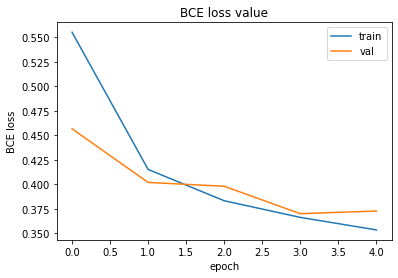

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.plot(losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

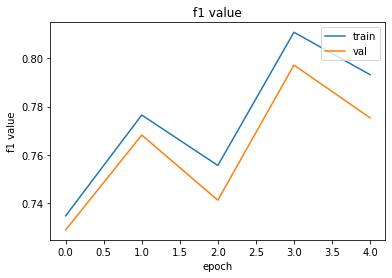

In [ ]:
import matplotlib.pyplot as plt
plt.plot([i.cpu() for i in f1s])
plt.plot([i.cpu() for i in f1s_eval])
plt.title('f1 value')
plt.ylabel('f1 value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

Для анализа ошибок можно посмотреть на те примеры, которые мы (не)правильно предсказываем

In [ ]:
def predict(model, iterator):
    model.eval()
    fp = []
    fn = []
    tp = [] 
    tn = []
    with torch.no_grad():
        for i, (words_batch, sym_batch, ys) in enumerate(iterator):   
            preds = model(sym_batch, words_batch)  # делаем предсказания на тесте 
            for pred, gold, text in zip(preds, ys, words_batch):
                text = ' '.join([id2word[int(word)] for word in text if word !=0])
                if round(pred.item()) > gold:
                    fp.append(text)
                elif round(pred.item()) < gold:
                    fn.append(text)
                elif round(pred.item()) == gold == 1:
                    tp.append(text)
                elif round(pred.item()) == gold == 0:
                    tn.append(text)
    return fp, fn, tp, tn

In [54]:
fp, fn, tp, tn = predict(model, val_iterator)

In [55]:
def get_metrics(fp, fn, tp, tn):
    all_preds = len(fp) + len(fn) + len(tp) + len(tn)
    print('accuracy')
    print((len(tp) + len(tn))/all_preds)
    print('precision')
    print(len(tp)/(len(fp) + len(tp)))
    print('recall')
    print(len(tp)/(len(fn) + len(tp)))

In [56]:
get_metrics(fp, fn, tp, tn)

accuracy
0.7983811626195733
precision
0.878796528887874
recall
0.6984753607405391


In [57]:
print('действительно позитивные:', tp[:10])

действительно позитивные: ['вот да ибо мой творческий натура не на простор контакт в :d', 'q посмотреть страница вк :) a', 'бе шд тэ хэхэ :-))', 'весь поздравлять с день :)', ':)', 'он смочь сделать это вечер :-) instantfollowback', 'была вчера в " " там целый поляна - " рождественский звезда " :)', 'когда он писать в твой тетрадка когда ты это :*', 'энэ намайг дээр бсан юм бэ', 'мне всегда нравиться парень которые старший меня :d я с ним иногда в вк переписываться но в реал ни разу не разговаривать']


In [58]:
print('ошибочно негативные:', fn[:10])

ошибочно негативные: ['exo ~ / /', 'перед обед был билет я решить после обед когда вернуться его уже купить теперь волос на себя', 'вот еще один " вариант " хотеть незабываемый массаж от кошечка только на русский язык', 'точно футболка совсем не заметить что другая хах', 'ну не фига тебе так', 'когда нужно читать по autofollowback', 'аааа ну и я знать знакомая и вполне знаменитый личность', 'а слышать да но так и не прочитать там же с ошибаться ..', 'rt сегодня с из - за 5 рубль вот мне делать нечего ...', 'ахах нет я писать не уметь только']


In [59]:
print('ошибочно позитивные:', fp[:10])

ошибочно позитивные: ['бляха шо щас і а вона не', 'увы пока ты ее она будет уже больший', 'песня не открыться а так спасибо большой мне очень приятный что вы не забывать обо ❤', '@asutka999 @stasy_spn @mahdapiha', 'rt в голова знание по ... %', '@cheko_ov я очень рад очень - очень - очень рад', '_ 33', 'то быть будешь встречать только с', 'давать за ночь килограмм уйти который я с больший труд набирать', 'сегодня ж её жёсткий полёт в школа']


In [60]:
print('действительно позитивные:', tn[:10])

действительно позитивные: ['здесь стремно такой звук :(', 'ну вот опять :( аж глаз ...', 'короче еще больше чем', 'бля зачем я это увидеть', 'мороз стоять жуткий photo путешествие …', 'полночь башка и утро совсем разбить', 'пойти выпью ~ ru_ff ff_ru', 'смотреть концерт и понимать что а мочь я так и не попасть на его концерт', 'блиииин завтра и история', 'снег почти весь такой под нога']


Не такое качество, как та тех, что с пунктуацией, но гораздо более красиво, чем просто на словах (не лемматизированных и без символов)